Read Data First

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({
    'font.size': 21,
    'xtick.labelsize': 19,
    'ytick.labelsize': 19,
    'figure.figsize':[16.0, 8.0]
})

In [2]:
def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(x / 1000.0)
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
yfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here

#plt.gca().yaxis.set_major_formatter(yfmt)

# final step
#pylab.savefig("Output.pdf", dpi=400, bbox_inches='tight', pad_inches=1)

In [71]:
file_path = "Data_BOUN_BUT/new_data/"
figures_path = "figures/study_figures/modelling_figures_2022/"
siteA_folder = "A-last.xlsx"
siteB_folder = "B-last.xlsx"
siteC_folder = "C-last.xlsx"
siteD_folder = "D-last.xlsx"
handover = "HO_RTB.xlsx"
enb1 = "eNodeB1"
enb2 = "eNodeB2"
enb3 = "eNodeB3"
siteA = "site A"
siteB = "site B"
siteC = "site C"
siteD = "site D"
data_columns = {"Unnamed: 0":"date", "Data Vol DL (MBytes)":"vol_dl", "Data Vol UL (MBytes)":"vol_ul", "Pctl95 TA [Miles]":"range", "Tput DL (Mbps)":"tput_dl", "Tput UL (Mbps)":"tput_ul"}
ploss_columns = {"Unnamed: 0":"date", "UL Ploss total %":"ploss_ul", "DL Ploss total %":"ploss_dl", "eERL #":"erlang", "DRB (Total) DCR %":"total_dcr", "ERB5 DCR %":"erb5_dcr", "ERB1 noCRE DCR %":"erb1_dcr"}
ho_columns = {"Unnamed: 0":"date", "D Incoming HO #":"ho_in", "D Outgoing HO #":"ho_out"}
sheet_list = ["eNodeB1 - DATA", "eNodeB1 - PLOSS", "eNodeB2 - DATA", "eNodeB2 - PLOSS", "eNodeB3 - DATA", "eNodeB3 - PLOSS"]

In [72]:
def seperate_date(s):
    t = s["date"].split(" ")
    s["date"] = t[0]
    s["time"] = t[1]
    return s
def get_date_fields(x):
    date_parts = x['date'].split("/")
    x['day'] = date_parts[1]
    x['month'] = date_parts[0]
    x['year'] = date_parts[2]
    return x

def create_number_of_bbu(x):
    dl_bbu = x['vol_dl'] // DL_CAPACITY
    ul_bbu = x['vol_ul'] // UL_CAPACITY
    x['num_bbu'] = max(dl_bbu, ul_bbu)
    return x

def get_sortable_date_field(x):
    x["date_for_sort"] = f"{x['year']}-{x['month']}-{x['day']}-{x['time']}"
    return x

def merge_df_list(df_list, index = "date", join="inner"):
    [df.set_index(index) for df in df_list]
    df = pd.concat(df_list, axis = 1, join = join)
    df = df.loc[:,~df.columns.duplicated()]
    return df

def get_data_df(df):
    df = df[["date", "vol_dl", "vol_ul", "tput_dl", "tput_ul"]]
    df = df[df["vol_dl"] != "-"]
    df = df[df["vol_ul"] != "-"]
    df = df[df["tput_dl"] != "-"]
    df = df[df["tput_ul"] != "-"]
    df.loc[:, df.columns != "date"] = df.loc[:, df.columns != "date"].apply(pd.to_numeric)
    return df

def get_enodeb_data(site_folder, site, enb):
    rows_to_skip = 1
    df1 = pd.read_excel(file_path+site_folder, sheet_name = f"{enb} - DATA", skiprows=rows_to_skip, engine='openpyxl')
    df2 = pd.read_excel(file_path+site_folder, sheet_name = f"{enb} - PLOSS", skiprows=rows_to_skip, engine='openpyxl')
    #df3 = pd.read_excel(file_path+handover, sheet_name = f"{enb} - {site}", skiprows=rows_to_skip, engine='openpyxl')
    df1.rename(columns=data_columns, inplace = True)
    df2.rename(columns=ploss_columns, inplace = True)
    #df3.rename(columns=ho_columns, inplace = True)
    df1 = get_data_df(df1)
    df2 = df2[["date", "ploss_ul", "ploss_dl", "erlang", "total_dcr", "erb5_dcr","erb1_dcr"]]
    #df3 = df3[["date", "ho_in", "ho_out"]] 
    #df_list = [df1,df2,df3]
    df_list = [df1,df2]
    df = merge_df_list(df_list)
    df["date_orj"] = df["date"]
    df = df.apply(seperate_date, axis = 1)
    df = df.apply(lambda x: get_date_fields(x), axis = 1)
    #df = df.apply(create_number_of_bbu, axis = 1)
    df = df.apply(get_sortable_date_field, axis = 1)
    df["num_ue_dl"] = df["vol_dl"] / df["tput_dl"]
    df["num_ue_ul"] = df["vol_ul"] / df["tput_ul"]
    print("DF creation complete")
    return df

In [73]:
def get_folder_and_site_dir(site_option):
    folder = ""
    site = ""
    return {
        "A": (siteA_folder, siteA),
        "B": (siteB_folder, siteB),
        "C": (siteC_folder, siteC),
        "D": (siteD_folder, siteD)
    }[site_option]
    
def get_merged_site_df_with_seperate_enb(site_option):
    folder,site  = get_folder_and_site_dir(site_option)
    e1df = get_enodeb_data(folder, site, enb1)
    e2df = get_enodeb_data(folder, site, enb2)
    e3df = get_enodeb_data(folder, site, enb3)
    site_df = pd.concat([e1df,e2df,e3df])
    site_df = site_df.sort_values("date_for_sort")
    print("ENB Data is read")
    return site_df

def get_grouped_site_df(site_df):
    site_df['erb1_dcr'] =pd.to_numeric(site_df['erb1_dcr'], errors="coerce")
    #site_df['ho_in'] = pd.to_numeric(site_df.ho_in, errors="coerce")
    #site_df['ho_out'] = pd.to_numeric(site_df.ho_out, errors="coerce")
    #site_df['erlang'] = pd.to_numeric(site_df['erlang'], errors="coerce")
    grp_site_df = site_df.groupby(['date_for_sort'], as_index=True).mean()
    print("Site is created")
    return grp_site_df


In [99]:
site_name = "D"
site_df = get_merged_site_df_with_seperate_enb(site_name)
grp_site_df = get_grouped_site_df(site_df)

DF creation complete
DF creation complete
DF creation complete
ENB Data is read
Site is created


In [100]:
df = grp_site_df[['vol_dl','vol_ul','tput_dl','tput_ul','num_ue_dl','num_ue_ul']]

In [101]:
def shift_col_by_number(df, column, number_of_shifts):
    for x in range(1, number_of_shifts+1):
        df[f"{column}_pre_{x}"] = df[column].shift(x)
    return df
df = shift_col_by_number(df, "vol_dl", 4)
df = shift_col_by_number(df, "vol_ul", 4)
df = shift_col_by_number(df, "tput_dl", 4)
df = shift_col_by_number(df, "tput_ul", 4)
df = shift_col_by_number(df, "num_ue_dl", 4)
df = shift_col_by_number(df, "num_ue_ul", 4)
df = df.dropna()

Modelling with LSTM

In [102]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


In [103]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [104]:
X = df.drop(['vol_dl','vol_ul'], axis = 1)
y = df[['vol_dl','vol_ul']]
# X = df.drop(['tput_dl','tput_ul'], axis = 1)
# y = df[['tput_dl','tput_ul']]

def get_datasets(input_scaler, output_scaler): 
    X_train, X_test, y_train, y_test = tts(X,y, shuffle=False)
    input_scaler.fit(X_train)
    X_train = input_scaler.transform(X_train)
    X_test = input_scaler.transform(X_test)
    output_scaler.fit(y_train)
    y_train = output_scaler.transform(y_train)
    y_test = output_scaler.transform(y_test)
    return X_train, X_test, y_train, y_test, input_scaler, output_scaler

X_train, X_test, y_train, y_test, input_scaler, output_scaler = get_datasets(MinMaxScaler(),MinMaxScaler())

In [105]:
#output_scaler.inverse_transform(y_train)
#input_scaler.inverse_transform(X_train)

In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Dropout, LeakyReLU
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [107]:
# Reshape X train and test for LSTM inputs
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [108]:
try:
    del history
    del model
except:
    print("Already deleted")

In [109]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(LSTM(30, input_shape = (train_X.shape[1], train_X.shape[2])))
#model.add(Dense(100, input_dim=17, kernel_initializer='normal', activation='linear'))
model.add(Dense(50,kernel_initializer='normal', activation='linear'))
#model.add(Dropout(0.2))

#model.add(Dense(50,kernel_initializer='normal', activation='linear'))
#model.add(Dense(50,kernel_initializer='normal', activation='linear'))
#model.add(Dropout(0.12))

model.add(Dense(15,kernel_initializer='normal', activation='elu'))
model.add(Dense(15,kernel_initializer='normal', activation='elu'))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam')

In [110]:
history = model.fit(X_train, y_train, epochs=60, batch_size=25, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Train on 3559 samples, validate on 1187 samples
Epoch 1/60
3559/3559 [==============================] - 2s 561us/step - loss: 0.3388 - val_loss: 0.2477
Epoch 2/60
3559/3559 [==============================] - 1s 217us/step - loss: 0.1309 - val_loss: 0.1567
Epoch 3/60
3559/3559 [==============================] - 1s 215us/step - loss: 0.0883 - val_loss: 0.0708
Epoch 4/60
3559/3559 [==============================] - 1s 217us/step - loss: 0.0702 - val_loss: 0.1237
Epoch 5/60
3559/3559 [==============================] - 1s 215us/step - loss: 0.0662 - val_loss: 0.1184
Epoch 6/60
3559/3559 [==============================] - 1s 209us/step - loss: 0.0594 - val_loss: 0.0508
Epoch 7/60
3559/3559 [==============================] - 1s 209us/step - loss: 0.0545 - val_loss: 0.0479
Epoch 8/60
3559/3559 [==============================] - 1s 216us/step - loss: 0.0509 - val_loss: 0.0467
Epoch 9/60
3559/3559 [==============================] - 1s 211us/step - loss: 0.0541 - val_loss: 0.0451
Epoch 10/60
3559

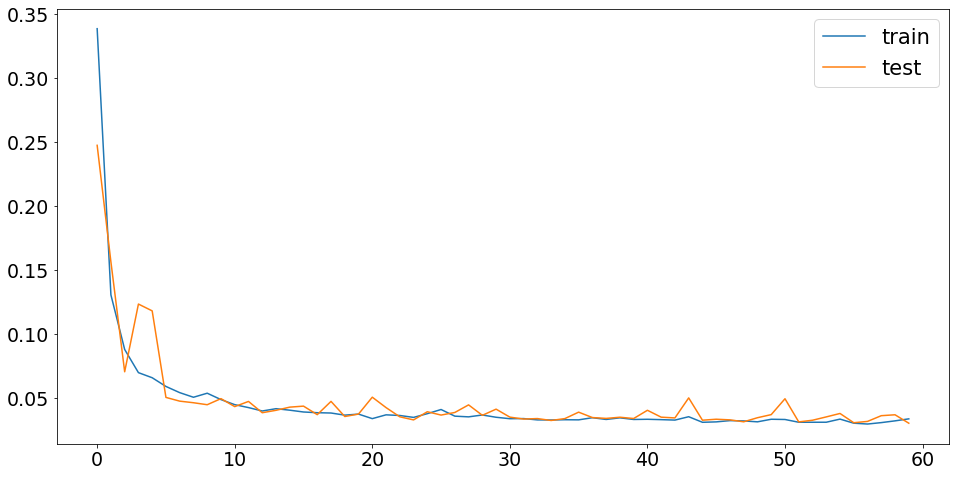

In [111]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [112]:
# Make prediction of test 
yhat = model.predict(X_test)

In [113]:
# Invert reshaping of X
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

In [114]:
inv_yhat = output_scaler.inverse_transform(yhat)

In [115]:
inv_y_test = output_scaler.inverse_transform(y_test)

In [116]:
def print_errors(y_true, y_pred):
    error = (mean_absolute_percentage_error(y_true, y_pred))
    error_mae = mean_absolute_error(y_true, y_pred)
    print('MAPE: %.6f' % error)
    print('MAE: %.6f' % error_mae)
    

In [117]:
print("DL Results")
print_errors(inv_y_test[:,0], inv_yhat[:,0])

DL Results
MAPE: 6.805527
MAE: 460.765455


In [118]:
print("UL Results")
print_errors(inv_y_test[:,1], inv_yhat[:,1])

UL Results
MAPE: 8.277469
MAE: 86.723036


In [119]:
date_index = y.reset_index()['date_for_sort'].loc[y_train.shape[0]:]
date_index = pd.to_datetime(date_index)

In [120]:
# For c, week is 4 02-08 den basliyor, for A, week is 2
base = 12
week = 2
day = 15 # 12 saturday 13 sunday, 14 monday, 15 tuesday, 16 wednesday, 17 thursday, 18 friday
additive_days = 24 * day
additive_week = 168 * week
time_labels = [f"{x}:00" if len(str(x)) != 1 else f"0{x}:00" for x in range(24)]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

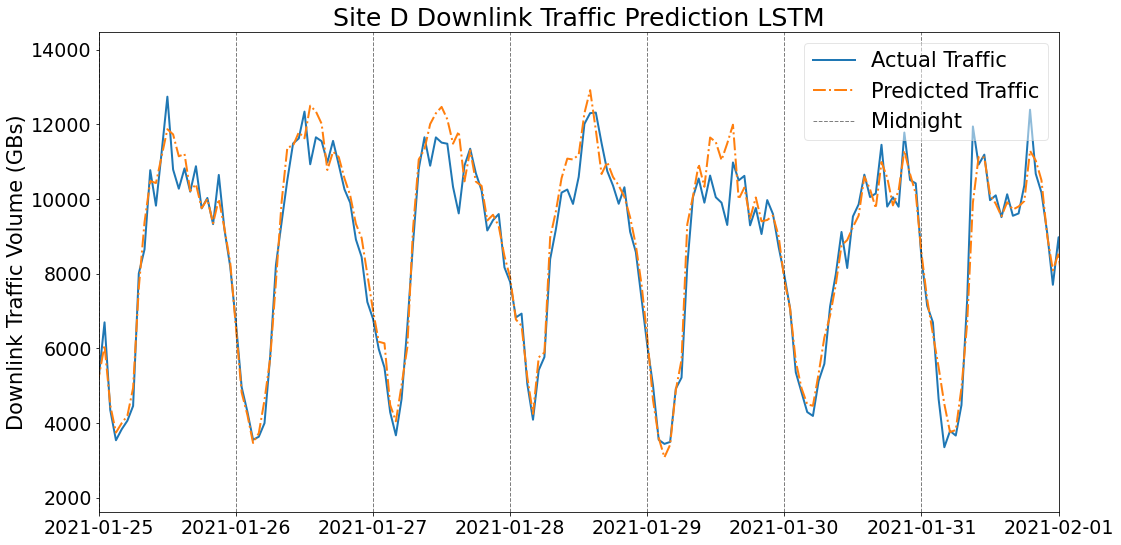

In [121]:
def create_weekly_plot(start_day, end_day, name, save_fig = False): 
    plt.figure(figsize=(16,8))
    plt.plot(date_index, inv_y_test[:,0] + inv_y_test[:,1], lw = 2, label = "Actual Traffic")
    plt.plot(date_index, inv_yhat[:,0] + inv_y_test[:,1], ls = "-.", lw = 2, label = "Predicted Traffic")
    plt.xlim(date_index.iloc[start_day], date_index.iloc[end_day])
    plt.title(f"Site {site_name} Downlink Traffic Prediction LSTM")
    plt.ylabel("Downlink Traffic Volume (GBs)")
    #plt.xlabel("Days")
    plt.xticks(rotation=0)
    ttime = date_index.iloc[start_day:end_day]
    flag = True
    for xc in pd.date_range(ttime.min(),ttime.max(),freq='d'):
        if flag:
            flag = False
            plt.axvline(x=xc, color='black', linestyle='--', alpha=0.5, lw = 1, label = "Midnight")
        else:
            plt.axvline(x=xc, color='black', linestyle='--', alpha=0.5, lw = 1)
        
    plt.legend(framealpha = 0.50)
    #plt.gca().yaxis.set_major_formatter(yfmt)
    plt.tight_layout()
    if (save_fig):
        plt.savefig(figures_path + name + "_lstm.pdf", format = "pdf")
        plt.savefig(figures_path + name + "_lstm.eps", format = "eps")
    plt.show()

create_weekly_plot(base+additive_week, base+additive_week+168, f"{site_name}_DL_week", save_fig = True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

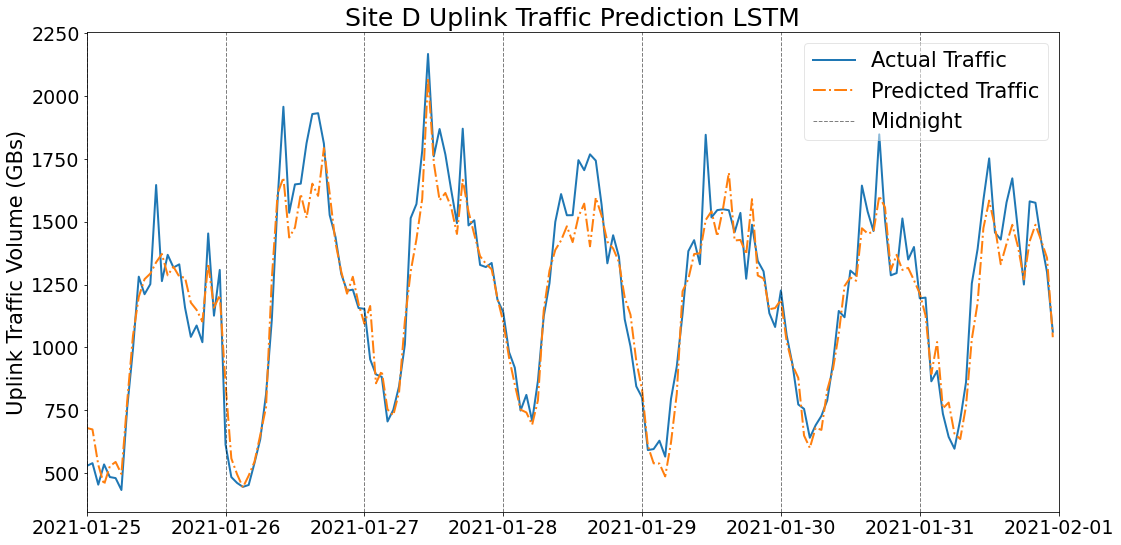

In [122]:
def create_weekly_plot_ul(start_day, end_day, name, save_fig = False): 
    plt.figure(figsize=(16,8))
    plt.plot(date_index[start_day:end_day], inv_y_test[start_day:end_day,1], lw = 2, label = "Actual Traffic")
    plt.plot(date_index[start_day:end_day], inv_yhat[start_day:end_day,1],ls = "-.", lw = 2, label = "Predicted Traffic")
    plt.xlim(date_index.iloc[start_day], date_index.iloc[end_day])
    start, end = plt.ylim()
    stepsize = 600
    #plt.yticks(np.arange(600, end, stepsize))
    #plt.ylim(date_index.iloc[start_day], date_index.iloc[end_day])
    plt.title(f"Site {site_name} Uplink Traffic Prediction LSTM")
    plt.ylabel("Uplink Traffic Volume (GBs)")
    #plt.xlabel("Days")
    plt.xticks(rotation=0)
    ttime = date_index.iloc[start_day:end_day]
    flag = True
    for xc in pd.date_range(ttime.min(),ttime.max(),freq='d'):
        if flag:
            flag = False
            plt.axvline(x=xc, color='black', linestyle='--', alpha=0.5, lw = 1, label = "Midnight")
        else:
            plt.axvline(x=xc, color='black', linestyle='--', alpha=0.5, lw = 1)
        
    plt.legend(framealpha = 0.50)
    #plt.gca().yaxis.set_major_formatter(yfmt)
    plt.tight_layout()
    if (save_fig):
        plt.savefig(figures_path + name + "_lstm.pdf", format = "pdf")
        plt.savefig(figures_path + name + "_lstm.eps", format = "eps")
    plt.show()

create_weekly_plot_ul(base+additive_week, base+additive_week+168, f"{site_name}_UL_week", save_fig = True)

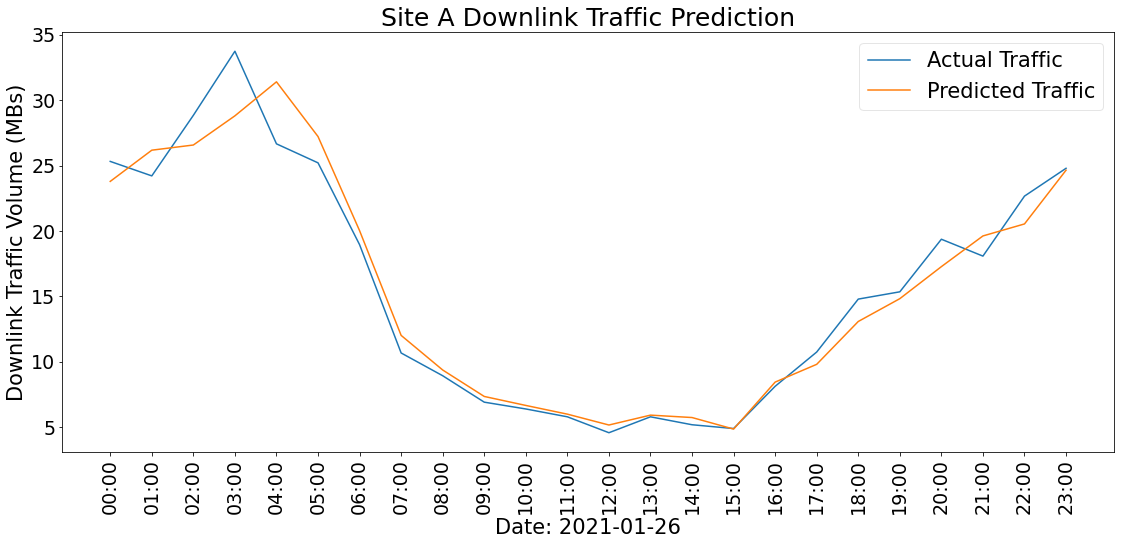

In [227]:
def create_daily_plot(start_day, end_day, name, direction, save_fig = False):
    col = 1 if direction == "ul" else 0
    top_name = "Uplink" if direction == "ul" else "Downlink"
    plt.figure(figsize=(16,8))
    plt.plot(date_index[start_day:end_day], inv_y_test[start_day:end_day,col], label = "Actual Traffic")
    plt.plot(date_index[start_day:end_day], inv_yhat[start_day:end_day,col], label = "Predicted Traffic")
    #plt.xlim(date_index.iloc[start_day], date_index.iloc[end_day])
    start, end = plt.ylim()
    #stepsize = 1000
    #plt.yticks(np.arange(7000, end, stepsize))
    #plt.ylim(date_index.iloc[start_day], date_index.iloc[end_day])
    plt.title(f"Site {site_name} {top_name} Traffic Prediction")
    plt.ylabel(f"{top_name} Traffic Volume (MBs)")
    plt.xlabel("Date: " + date_index.iloc[base+additive_days].strftime("%Y-%m-%d"))
    plt.xticks(date_index[start_day:end_day], time_labels, rotation=90)
    plt.legend(framealpha = 0.50)
    plt.tight_layout()
    if (save_fig):
        plt.savefig(figures_path + name + f"_{site_name}_{direction}_daily"+ ".pdf", format = "pdf")
        plt.savefig(figures_path + name + ".eps", format = "eps")
    plt.show()

create_daily_plot(base+additive_days, base+additive_days+24, f"new_site", "dl", save_fig = False)

/Users/sevgican/opt/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


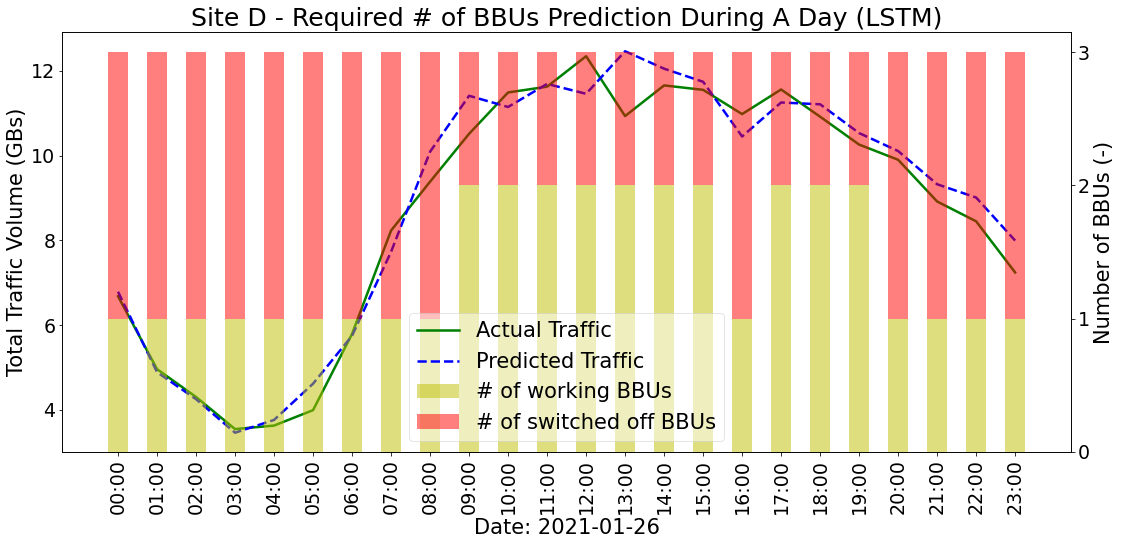

In [123]:
save_fig = False
bbu_cap = 10.5
def create_num_bbu_plot(start_day, end_day, save_fig = False):

    # start_day = base+additive_days
    # end_day = base+additive_days+24

    actual_sum_volume = (inv_y_test[start_day:end_day,0] + inv_y_test[start_day:end_day,1])/1000
    pred_sum_volume = (inv_yhat[start_day:end_day,0] + inv_yhat[start_day:end_day,1])/1000
    
    pred_num_bbu = [1 if x < bbu_cap else 3 if x > (bbu_cap*2) else 2 for x in pred_sum_volume]
    filler_num_bbu = [3-x for x in pred_num_bbu]
    #ax1 = sns.set_style(style=None, rc=None)

    fig, ax1 = plt.subplots(figsize=(16,8))
    ax2 = ax1.twinx()

    line3 = ax2.bar(time_labels, pred_num_bbu, width = 0.5, alpha = 0.5, color = "y")
    line4 = ax2.bar(time_labels, filler_num_bbu, bottom = pred_num_bbu, width = 0.5, alpha = 0.5, color = "r")
    line1, = ax1.plot(time_labels, actual_sum_volume, color = "g", lw = 2.5)
    line2, = ax1.plot(time_labels, pred_sum_volume, color = "b", ls = '--', lw = 2.5)
    ax1.set_xticklabels(time_labels, rotation = 90)
    ax2.set_yticks(np.arange(0,4,1))
    ax1.set_xlabel("Date: " + date_index.iloc[base+additive_days].strftime("%Y-%m-%d"))
    ax1.set_ylabel(f"Total Traffic Volume (GBs)")
    ax2.set_ylabel("Number of BBUs (-)")

    plt.title(f"Site {site_name} - Required # of BBUs Prediction During A Day (LSTM)")

    plt.legend((line1, line2, line3, line4), ['Actual Traffic', 'Predicted Traffic', '# of working BBUs', '# of switched off BBUs'],framealpha = 0.50, loc="lower center")

    plt.tight_layout()

    if (save_fig):
        plt.savefig(figures_path + f"{site_name}_bbu_prediction_lstm" + ".pdf", format = "pdf")
        #plt.savefig(figures_path + f"{site_name}_bbu_prediction" + ".eps", format = "eps")

    plt.show()
    
create_num_bbu_plot(base+additive_days, base+additive_days+24, save_fig = True)

Prophet Prediction

In [250]:
from fbprophet import Prophet

In [251]:
df_p = df.reset_index()
df_p.head()

,date_for_sort,vol_dl,vol_ul,tput_dl,tput_ul,num_ue_dl,num_ue_ul,vol_dl_pre_1,vol_dl_pre_2,vol_dl_pre_3,...,tput_ul_pre_3,tput_ul_pre_4,num_ue_dl_pre_1,num_ue_dl_pre_2,num_ue_dl_pre_3,num_ue_dl_pre_4,num_ue_ul_pre_1,num_ue_ul_pre_2,num_ue_ul_pre_3,num_ue_ul_pre_4
0,2020-08-15-04,5601.306667,483.850000,14.160000,1.303333,382.057637,395.906824,7072.543333,8445.513333,7987.326667,...,0.733333,0.796667,528.137151,798.406519,795.891905,860.351541,544.026736,787.466561,1006.719875,1088.922271
1,2020-08-15-05,3673.520000,368.686667,13.276667,0.876667,282.961796,392.966558,5601.306667,7072.543333,8445.513333,...,0.863333,0.733333,382.057637,528.137151,798.406519,795.891905,395.906824,544.026736,787.466561,1006.719875
2,2020-08-15-06,3773.520000,453.930000,15.610000,0.966667,261.498440,471.235069,3673.520000,5601.306667,7072.543333,...,1.060000,0.863333,282.961796,382.057637,528.137151,798.406519,392.966558,395.906824,544.026736,787.466561
3,2020-08-15-07,3653.076667,469.543333,12.400000,0.970000,320.320740,569.741247,3773.520000,3673.520000,5601.306667,...,1.303333,1.060000,261.498440,282.961796,382.057637,528.137151,471.235069,392.966558,395.906824,544.026736
4,2020-08-15-08,4163.440000,582.233333,11.753333,0.576667,365.496406,1018.420339,3653.076667,3773.520000,3673.520000,...,0.876667,1.303333,320.320740,261.498440,282.961796,382.057637,569.741247,471.235069,392.966558,395.906824


In [253]:
def get_results_prophet(df, direction):
    df_p = df.reset_index()
    reverse_direction = "dl"
    if direction == "dl":
        reverse_direction = "ul"
    df_p['ds'] = pd.to_datetime(df_p['date_for_sort'])
    df_p = df_p.drop(['date_for_sort', f'vol_{reverse_direction}'], axis = 1)
    df_p.rename(columns={f'vol_{direction}':'y'},inplace = True)
    cut_line = df_p.shape[0] // 4 * 3
    df_train = df_p.loc[:cut_line, :]
    df_test = df_p.loc[cut_line:, :]
    df_test_x = df_test.drop(['y'], axis = 1)
    try: 
        del model_p
        del df_yhat
    except:
        print("Already Deleted")
    model_p = Prophet()
    model_p.fit(df_train)
    df_yhat = model_p.predict(df_test_x)
    print(f"Prophet Results {direction}: ")
    print_errors(df_test['y'],df_yhat['yhat'])

get_results_prophet(df, "ul")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Already Deleted
Prophet Results ul: 
MAPE: 32.543782
MAE: 374.353155


In [202]:
df_p['ds'] = pd.to_datetime(df_p['date_for_sort'])
df_p = df_p.drop(['date_for_sort', 'vol_ul'], axis = 1)
df_p.rename(columns={'vol_dl':'y'},inplace = True)

In [203]:
cut_line = df_p.shape[0] // 4 * 3
cut_line

3558

In [204]:
df_train = df_p.loc[:cut_line, :]
df_test = df_p.loc[cut_line:, :]

In [205]:
df_test_x = df_test.drop(['y'], axis = 1)

In [206]:
try: 
    del model_p
    del df_yhat
except:
    print("Already Deleted")

In [101]:
model_p = Prophet()

In [102]:
model_p.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [103]:
df_yhat = model_p.predict(df_test_x)

In [104]:
df_yhat.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-10 11:00:00,12575.655899,12296.500164,19959.913091,12575.655899,12575.655899,3656.350626,3656.350626,3656.350626,7634.295391,7634.295391,7634.295391,-3977.944764,-3977.944764,-3977.944764,0.0,0.0,0.0,16232.006526
1,2021-01-10 12:00:00,12573.581624,13297.442678,21393.953264,12573.581624,12573.581624,4672.582337,4672.582337,4672.582337,8499.186120,8499.186120,8499.186120,-3826.603783,-3826.603783,-3826.603783,0.0,0.0,0.0,17246.163961
2,2021-01-10 13:00:00,12571.507348,13820.094332,21813.030855,12571.507348,12571.507348,5505.095276,5505.095276,5505.095276,9166.803853,9166.803853,9166.803853,-3661.708577,-3661.708577,-3661.708577,0.0,0.0,0.0,18076.602624
3,2021-01-10 14:00:00,12569.433073,14279.037963,22444.572454,12569.433073,12569.433073,5605.216327,5605.216327,5605.216327,9089.477765,9089.477765,9089.477765,-3484.261438,-3484.261438,-3484.261438,0.0,0.0,0.0,18174.649399
4,2021-01-10 15:00:00,12567.358797,13167.516578,20926.226741,12567.358797,12567.358797,4504.701917,4504.701917,4504.701917,7800.050366,7800.050366,7800.050366,-3295.348449,-3295.348449,-3295.348449,0.0,0.0,0.0,17072.060714


In [105]:
print("Prophet Results DL: ")
print_errors(df_test['y'],df_yhat['yhat'])

Prophet Results DL: 
MAPE: 29.323734
MAE: 3687.248110


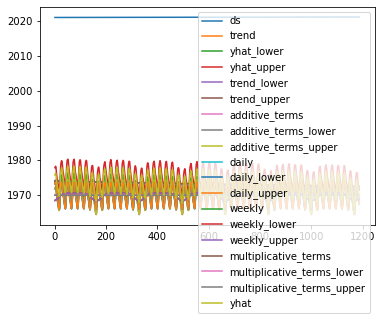

In [182]:
fig1 = df_yhat.plot()